# Model Comparisons

Please note: The (fixed) parameters 'alphas' and 'betas' for chebyshev approximations in this file have been precomputed using the 'learn_parameters_chebyshev' functions in the src/models/auxiliary_models.py file using 6 approximiation-steps, a training length of 20000 steps, the resp. config-dicts for the experiment settings and use_mlp, part_obs_constr - Flags set to (False, False), (False, True), (True, False), respectively.

### Setup:

**Imports, Paths, GPU-Settings and Flags:**

In [1]:
import os
import jax
import pickle as pkl
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state
from typing import Dict, List
from matplotlib import cm, colors

from configs.config import get_experiment_config, get_model_config
from src.training_init import TrainingInitializer
from src.models.auxiliary_models import LeastSquaresSequenceSolver
from src.util.sequence_performance.sequenceloss_eval import SequencePredictionEvaluator
from src.train import _compute_loss

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = jax.devices()

rerun_models = False
rerun_analyses = False
store_results = False
path_chebyshev = 'experiments/auxmodel_params/cheb_params.pkl'

path_model_fully_7 = 'experiment_results/linear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_fully_mesa = 'experiment_results/linear_seq_fully/model_mesa_fullfledged.pkl'
path_partobs_all_models = 'experiment_results/linear_seq_partial/all_models.pkl'
path_model_nonlin_7 = 'experiment_results/nonlinear_seq_fully/model_sm_7l_fullfledged.pkl'
path_model_nonlin_mesa = 'experiment_results/nonlinear_seq_fully/model_mesa_fullfledged.pkl'

path_comparison_fully = 'experiment_results/linear_seq_fully/comparison_results.pkl'
path_comparison_partobs = 'experiment_results/linear_seq_partial/comparison_results.pkl'
path_comparison_nonlin = 'experiment_results/nonlinear_seq_fully/comparison_results.pkl'

print(f'Running on Devices: {gpus},\nRe-Run Analysis: {rerun_analyses}, \nRe-Run Models: {rerun_models}, \nStore Results: {store_results}')

Running on Devices: [CpuDevice(id=0)],
Re-Run Analysis: False, 
Re-Run Models: False, 
Store Results: False


## Models trained on fully observerable linear dynamical systems:

In [7]:
models_full = {'full_seven_sm': 'fully_obs_full_fledged_transformer.6.4.40.50.20.True.False.False.False.0.False.False.0.False.False.False.False',
               'hybrid_mesa':          'fully_obs_full_fledged_mesa.1.4.40.50.20.True.False.False.False.0.False.True.1.False.False.False.False'}

Full-softmax:

In [18]:
exp_config_sensitivity = get_experiment_config(experiment='probing_full', seeds=[1, 11, 111, 1111, 11111])
(model_tf_full, optimizer, data_generator_fully, train_module) = TrainingInitializer(model_config=get_model_config(models_full['full_seven_sm']), 
                                                                                    experiment_config=exp_config_sensitivity).run()
if rerun_models:
    training_seed = 11111
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_full, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(100):
                        state_tf_full, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                                        state=state_tf_full,
                                                                                        rng=train_rng,
                                                                                        test_rng=test_rng,
                                                                                        num_batches_train=100,
                                                                                        interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_fully_7}\'')
        a = {'params' : state_tf_full.params}
        with open(path_model_fully_7, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fully_7, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_full = train_state.TrainState.create(apply_fn=model_tf_full.apply, params=a['params'], tx=optimizer)

model:  fully_obs_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0


Hybrid-Mesa:

In [19]:
exp_config_sensitivity = get_experiment_config(experiment='probing_full', seeds=[1, 11, 111, 1111, 11111])
exp_config_sensitivity.optim.peak_lr = 3e-4
(model_mesa_fully, optimizer, data_generator_fully, train_module) = TrainingInitializer(model_config=get_model_config(models_full['hybrid_mesa']), 
                                                                       experiment_config=exp_config_sensitivity).run()
if rerun_models:
    training_seed = 68
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa_fully, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(200):
        state_mesa_fully, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                        state=state_mesa_fully,
                                                                        rng=train_rng,
                                                                        test_rng=test_rng,
                                                                        num_batches_train=100,
                                                                        interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_fully_mesa}\'')
        a = {'params' : state_tf_full.params}
        with open(path_model_fully_mesa, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_fully_mesa, 'rb') as handle:
        a = pkl.load(handle)
    state_mesa_fully = train_state.TrainState.create(apply_fn=model_mesa_fully.apply, params=a['params'], tx=optimizer)

model:  fully_obs_full_fledged_mesa  layers: 1  heads:  4  embed_dim:  40  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1


In [20]:
lsq_solver_fully = LeastSquaresSequenceSolver(approximator='chebyshev',
                                                seq_len=50,
                                                apx_steps=20,
                                                lamb=0.001,
                                                alphas=[1.0292039, 3.8550997, 3.7469113, 3.3827868, 2.9881542, 2.0934358],
                                                betas=[0.0,        0.6402129, 0.4798134, 0.8143542, 1.6680348, 2.4196014])

lsq_solver_baseline_fully = LeastSquaresSequenceSolver(approximator='None',
                                                        seq_len=50,
                                                        lamb=0.001)

In [48]:
loss_fn = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator_fully,
                                            test_batch_size=256,
                                            seeds=exp_config_sensitivity.seeds,
                                            model_list = ['transformer', 'mesa-transformer', 'lsq', 'lsq'],
                                            models = [model_tf_full, model_mesa_fully, lsq_solver_fully, lsq_solver_baseline_fully],
                                            states = [state_tf_full, state_mesa_fully, None, None, None],
                                            loss_fn = loss_fn)

if rerun_analyses:
    seq_loss_dict_fully = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_comparison_fully}\'')
        with open(path_comparison_fully, 'wb') as handle:
            pkl.dump(seq_loss_dict_fully, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_comparison_fully, 'rb') as handle:
        seq_loss_dict_fully = pkl.load(handle)

## Models trained on partially observable linear dynamical systems:

In [4]:
sm_model_def = lambda dim : f'part_obs_full_fledged_transformer.6.12.{dim}.50.{min(20,dim)}.True.False.False.False.0.False.False.0.False.False.False.False'
mesa_model_def = lambda dim : f'part_obs_full_fledged_mesa.1.12.{dim}.50.{min(20,dim)}.True.False.False.False.0.False.True.1.False.False.False.False'

In [5]:
if rerun_models:
        params_list_sm_partobs = []
        params_list_mesa_partobs = []
        init_training_seed = 42
        exp_config_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
        for dimension in [5, 10, 15, 20, 30, 50, 80]:
                model_config_partobs_SM = get_model_config(sm_model_def(dimension))
                model_config_partobs_Mesa = get_model_config(mesa_model_def(dimension))
                (model_sm, optimizer_sm, data_generator_sm, train_module_sm) = TrainingInitializer(model_config=model_config_partobs_SM,
                                                                                                experiment_config=exp_config_partobs).run()
                (model_mesa, optimizer_mesa, data_generator_mesa, train_module_mesa) = TrainingInitializer(model_config=model_config_partobs_Mesa,
                                                                                                        experiment_config=exp_config_partobs).run()
                # Train Full Softmax Model:
                rng = jax.random.PRNGKey(init_training_seed)
                rng, test_rng, train_rng = jax.random.split(rng, 3)
                state_tf, rng = train_module_sm.get_init_state(rng, interpol_call=False)
                for epoch_idx in range(200):
                                state_tf, train_rng, _, _, _ = train_module_sm.train_epoch(epoch=epoch_idx,
                                                                                        state=state_tf,
                                                                                        rng=train_rng,
                                                                                        test_rng=test_rng,
                                                                                        num_batches_train=100,
                                                                                        interpolate=False)
                # Train Hybrid-Mesa Model:
                rng = jax.random.PRNGKey(init_training_seed)
                rng, test_rng, train_rng = jax.random.split(rng, 3)
                state_mesa, rng = train_module_mesa.get_init_state(rng, interpol_call=False)
                for epoch_idx in range(120):
                                state_mesa, train_rng, _, _, _ = train_module_mesa.train_epoch(epoch=epoch_idx,
                                                                                                state=state_mesa,
                                                                                                rng=train_rng,
                                                                                                test_rng=test_rng,
                                                                                                num_batches_train=100,
                                                                                                interpolate=False)
                params_list_sm_partobs.append(state_tf.params)
                params_list_mesa_partobs.append(state_mesa.params)
                if store_results:
                        print(f'Storing model paremeters in path=\'{path_partobs_all_models}\'')
                        results = {'partobs_models_sm' : params_list_sm_partobs,
                                'partobs_models_sm' : params_list_mesa_partobs}
                        with open(path_partobs_all_models, 'wb') as handle:
                                pkl.dump(results, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
        with open(path_partobs_all_models, 'rb') as handle:
                params_dict = pkl.load(handle)
        params_list_sm_partobs = params_dict['partobs_models_sm']
        params_list_mesa_partobs = params_dict['partobs_models_sm']
        exp_config_partobs = get_experiment_config(experiment='partobs', seeds=[1, 11, 111, 1111, 11111])
        models_sm, states_sm, models_mesa, states_mesa = [],[],[],[]
        for i, dim in enumerate([5, 10, 15, 20, 30, 50, 80]):
                model_config_partobs_SM = get_model_config(sm_model_def(dim))
                model_config_partobs_Mesa = get_model_config(mesa_model_def(dim))
                (model_sm, optimizer_sm, data_generator_sm, _) = TrainingInitializer(model_config=model_config_partobs_SM,
                                                                experiment_config=exp_config_partobs).run()
                (model_mesa, optimizer_mesa, data_generator_mesa, _) = TrainingInitializer(model_config=model_config_partobs_Mesa,
                                                                        experiment_config=exp_config_partobs).run()
                state_tf = train_state.TrainState.create(apply_fn=model_sm.apply, params=params_list_sm_partobs[i], tx=optimizer_sm)
                state_mesa = train_state.TrainState.create(apply_fn=model_mesa.apply, params=params_list_mesa_partobs[i], tx=optimizer_mesa)
                models_sm.append(model_sm)
                models_mesa.append(model_mesa)
                states_sm.append(state_tf)
                states_mesa.append(state_mesa)

model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  5  seq_len:  50  key_size:  5  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  part_obs_full_fledged_mesa  layers: 1  heads:  12  embed_dim:  5  seq_len:  50  key_size:  5  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1
model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  10  seq_len:  50  key_size:  10  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  False  clip_val:  0
model:  part_obs_full_fledged_mesa  layers: 1  heads:  12  embed_dim:  10  seq_len:  50  key_size:  10  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  False  dim_mlp:  0  linear:  False  clip:  True  clip_val:  1
model:  part_obs_full_fledged_transformer  layers: 6  heads:  12  embed_dim:  15  seq_len:  50  key_size:  15  p

In [26]:
lsq_solver_smart = LeastSquaresSequenceSolver(approximator='chebyshev',
                                            seq_len=50,
                                            apx_steps=6,
                                            lamb=10,
                                            alphas=[1.0931315, 3.109863, 3.1626225, 3.0759215, 1.9025781, 0.22242576],
                                            betas=[0.0, 0.7379088, 0.18275392, 0.7571611, 1.2497796, 2.2919629 ])
lsq_solver_naive = LeastSquaresSequenceSolver(approximator='chebyshev',
                                            seq_len=50,
                                            apx_steps=6,
                                            lamb=10,
                                            alphas=[1.0931315, 3.109863, 3.1626225, 3.0759215, 1.9025781, 0.22242576],
                                            betas=[0.0, 0.7379088, 0.18275392, 0.7571611, 1.2497796, 2.2919629 ])

In [27]:
if rerun_models:
    opt_l = lsq_solver_smart.opt_lamb(minv=0.001, 
                                        maxv=10, 
                                        steps=25, 
                                        data_generator=data_generator_sm,
                                        loss_fn=_compute_loss,
                                        part_obs_constr=True,
                                        embed_dim=80)
    opt_l_naive = lsq_solver_naive.opt_lamb(minv=0.001, 
                                        maxv=100, 
                                        steps=50, 
                                        data_generator=data_generator_sm,
                                        loss_fn=_compute_loss,
                                        part_obs_constr=False)

In [49]:
model_list = ['transformer', 'mesa-transformer', 'lsq', 'lsq_partobs']
loss_fn_seq = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator_sm,
                                            test_batch_size=512,
                                            seeds=exp_config_partobs.seeds,
                                            model_list = model_list,
                                            models = [models_sm[-1], models_mesa[-1], lsq_solver_naive, lsq_solver_smart],
                                            states = [states_sm[-1], states_mesa[-1], None, 80],
                                            loss_fn = loss_fn_seq)

if rerun_analyses:
    seq_loss_dict_partobs = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_comparison_partobs}\'')
        with open(path_comparison_partobs, 'wb') as handle:
            pkl.dump(seq_loss_dict_partobs, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_comparison_partobs, 'rb') as handle:
        seq_loss_dict_partobs = pkl.load(handle)

## Models trained on fully observable nonlinear dynamical systems:

In [29]:
models_nonlin = {'nonlin_seven_sm': 'nonlinear_full_fledged_transformer.6.4.60.50.20.True.False.False.True.300.False.False.0.True.False.False.False',
                 'nonlin_mesa':            'fully_obs_full_fledged_mesa.1.4.60.50.20.True.False.False.True.300.False.True.15.True.False.False.False'}

In [34]:
exp_config_nonlin = get_experiment_config('nonlin', seeds=[1,11,111,1111,11111])
model_config = get_model_config(models_nonlin['nonlin_seven_sm'])
(model_tf_nonlin, optimizer, data_generator_nonlin, train_module) = TrainingInitializer(model_config=model_config, 
                                                                                        experiment_config=exp_config_nonlin).run()
if rerun_models:
    training_seed = 1
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_tf_nonlin, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(400):
        state_tf_nonlin, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                        state=state_tf_nonlin,
                                                                        rng=train_rng,
                                                                        test_rng=test_rng,
                                                                        num_batches_train=100,
                                                                        interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_nonlin_7}\'')
        a = {'params' : state_tf_nonlin.params}
        with open(path_model_nonlin_7, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_nonlin_7, 'rb') as handle:
        a = pkl.load(handle)
    state_tf_nonlin = train_state.TrainState.create(apply_fn=model_tf_nonlin.apply, params=a['params'], tx=optimizer)

model:  nonlinear_full_fledged_transformer  layers: 6  heads:  4  embed_dim:  60  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  True  dim_mlp:  300  linear:  False  clip:  False  clip_val:  0


In [35]:
(model_mesa_nonlin, optimizer, data_generator_nonlin, train_module) = TrainingInitializer(model_config=get_model_config(models_nonlin['nonlin_mesa']), 
                                                                       experiment_config=exp_config_nonlin).run()
if rerun_models:
    training_seed = 1
    rng = jax.random.PRNGKey(training_seed)
    rng, test_rng, train_rng = jax.random.split(rng, 3)
    state_mesa_nonlin, rng = train_module.get_init_state(rng, interpol_call=False)
    for epoch_idx in range(400):
                        state_mesa_nonlin, train_rng, _, _, _ = train_module.train_epoch(epoch=epoch_idx,
                                                                                        state=state_mesa_nonlin,
                                                                                        rng=train_rng,
                                                                                        test_rng=test_rng,
                                                                                        num_batches_train=100,
                                                                                        interpolate=False)
    if store_results:
        print(f'Storing results in path=\'{path_model_nonlin_mesa}\'')
        a = {'params' : state_mesa_nonlin.params}
        with open(path_model_nonlin_mesa, 'wb') as handle:
            pkl.dump(a, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_model_nonlin_mesa, 'rb') as handle:
        a = pkl.load(handle)
    state_mesa_nonlin = train_state.TrainState.create(apply_fn=model_mesa_nonlin.apply, params=a['params'], tx=optimizer)

model:  fully_obs_full_fledged_mesa  layers: 1  heads:  4  embed_dim:  60  seq_len:  50  key_size:  20  pe_kq:  True  pe_emb:  False  laynorm:  False  mlp:  True  dim_mlp:  300  linear:  False  clip:  True  clip_val:  15


In [36]:
loss_fn_seq = lambda p, t : list((jax.numpy.sum(((p - t)**2), axis=(0,2))/(2*p.shape[0])))

lsq_solver_smart = LeastSquaresSequenceSolver(approximator='chebyshev',
                                              seq_len=50,
                                              apx_steps=6,
                                              lamb=0.001,
                                              use_mlp=True,
                                              mlp_fn=data_generator_nonlin._mini_mlp,
                                              alphas=[1.0030721, 4.0157757, 3.866156, 3.3217084, 2.7570639, 2.1692858],
                                              betas=[0.0, 0.56304085, 0.566149, 0.9348311, 1.5603266, 2.425832])
lsq_solver_naive = LeastSquaresSequenceSolver(approximator='chebyshev',
                                              seq_len=50,
                                              apx_steps=6,
                                              lamb=0.001,
                                              use_mlp=False,
                                              mlp_fn=None,
                                              alphas=[1.0030721, 4.0157757, 3.866156, 3.3217084, 2.7570639, 2.1692858],
                                              betas=[0.0, 0.56304085, 0.566149, 0.9348311, 1.5603266, 2.425832])
if rerun_models:
    opt_l = lsq_solver_smart.opt_lamb(minv=0.001, 
                                        maxv=1, 
                                        steps=25, 
                                        data_generator=data_generator_nonlin,
                                        loss_fn=_compute_loss,
                                        part_obs_constr=False)
    opt_l_naive = lsq_solver_naive.opt_lamb(minv=0.001, 
                                        maxv=1, 
                                        steps=25, 
                                        data_generator=data_generator_nonlin,
                                        loss_fn=_compute_loss,
                                        part_obs_constr=False)

In [50]:
model_list = ['transformer', 'mesa-transformer', 'lsq', 'lsq_mlp']
seq_evaluator = SequencePredictionEvaluator(data_generator=data_generator_nonlin,
                                            test_batch_size=512,
                                            seeds=exp_config_partobs.seeds,
                                            model_list = model_list,
                                            models = [model_tf_nonlin, model_mesa_nonlin, lsq_solver_naive, lsq_solver_smart],
                                            states = [state_tf_nonlin, state_mesa_nonlin, None, data_generator_nonlin._mini_mlp],
                                            loss_fn = loss_fn_seq)

if rerun_analyses:
    seq_loss_dict_nonlin = seq_evaluator.run()
    if store_results:
        print(f'Storing performance evaluation dict. in path=\'{path_comparison_nonlin}\'')
        with open(path_comparison_nonlin, 'wb') as handle:
            pkl.dump(seq_loss_dict_nonlin, handle, protocol=pkl.HIGHEST_PROTOCOL)
else:
    with open(path_comparison_nonlin, 'rb') as handle:
        seq_loss_dict_nonlin = pkl.load(handle)

## Visualization of Results:

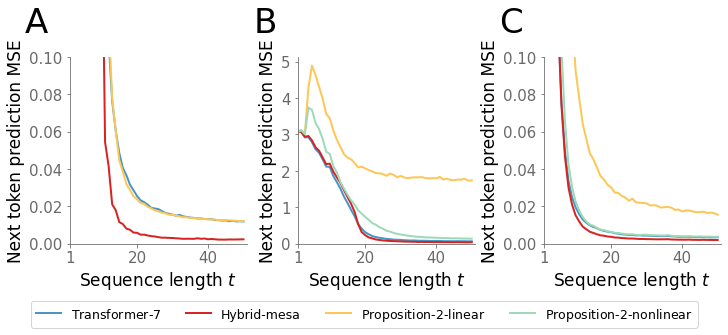

In [51]:
legend_fontsize = 'small'

def subplot_perf(ax,
                 seq_loss_dict: Dict[str, any],
                 model_list: List[str],
                 cols: List):
    loss_list = seq_loss_dict['losses']
    loss_arr = jnp.array(loss_list)
    mean_losses = tuple([jnp.mean(loss_arr[idx],axis=0) for idx in range(len(model_list))]) 
    std_losses = tuple([jnp.std(loss_arr[idx],axis=0) for idx in range(len(model_list))])
    for idx in range(len(model_list)):
        if model_list[idx] in ['Transformer-$12$', 'Proposition-$2$-linear-12']: # Quick fix
            continue
        ax.plot(mean_losses[idx], linewidth=2, label=model_list[idx], color=cols[idx])
        ax.fill_between(range(len(mean_losses[0])),
                        (mean_losses[idx] - std_losses[idx]),
                        (mean_losses[idx] - std_losses[idx]),
                        alpha=0.3,
                        facecolor=cols[idx])
    ax.tick_params(axis='x', colors='dimgray')
    ax.tick_params(axis='y', colors='dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['left'].set_color('dimgray')
    ax.set_xlabel('Sequence length $t$')
    ax.set_ylabel('Next token prediction MSE')
    ax.set_xlim(0,50)
    ax.set_ylim(0,)
    ax.set_xticks([0,19,39],[1,20,40])

def plot_comparison(seq_loss_dict_fully: Dict[str, any],
                    seq_loss_dict_part: Dict[str, any],
                    seq_loss_dict_nonlin: Dict[str, any],
                    model_list_full: List[str],
                    model_list_part: List[str],
                    model_list_nonlin: List[str]):

    plt.rcParams.update({'font.size': 15})
    plt.rc('axes', labelsize=17)
    plt.rcParams.update({
        "text.usetex": False,
    })

    colormap_sm = plt.get_cmap('Blues', 100)

    c_tf = colormap_sm(60)
    c_tf12 = colormap_sm(90)
    c_lsq = plt.get_cmap('YlOrBr', 100)(36)
    c_lsq12 = plt.get_cmap('YlOrBr', 100)(56)
    c_lsq_smart = plt.get_cmap('GnBu', 100)(40)
    c_mesa = plt.get_cmap('Reds', 100)(70)

    cols_p_full = [c_tf, c_tf12, c_mesa, c_lsq, c_lsq12]
    cols_p_part = [c_tf, c_mesa, c_lsq, c_lsq_smart]
    cols_p_nonlin = [c_tf, c_mesa, c_lsq, c_lsq_smart]

    fig, axs = plt.subplots(nrows=1,
                            ncols=3,
                            figsize=(10, 4),
                            gridspec_kw={'width_ratios': [1,1,1]},
                            layout='constrained')

    ################################################
    # Performance - Analyses:
    subplot_perf(ax=axs[0],
                 seq_loss_dict=seq_loss_dict_fully,
                 model_list=model_list_full,
                 cols=cols_p_full)
    axs[0].set_ylim(0,0.1)

    ################################################
    # Performance - Analyses:
    subplot_perf(ax=axs[1],
                 seq_loss_dict=seq_loss_dict_part,
                 model_list=model_list_part,
                 cols=cols_p_part)

    ################################################
    # Performance - Analyses:
    subplot_perf(ax=axs[2],
                 seq_loss_dict=seq_loss_dict_nonlin,
                 model_list=model_list_nonlin,
                 cols=cols_p_nonlin)
    axs[2].set_ylim(0,0.1)
    
    ################################################
    # Legend:
    handles, labels = axs[1].get_legend_handles_labels()
    l5 = fig.legend(handles, labels, bbox_to_anchor=(0.5, 0), loc="upper center",
                    bbox_transform=fig.transFigure, ncol=4, fontsize=legend_fontsize,
                    frameon=True)
    ################################################
    label_size = 34
    axs[0].text(-0.25, 1.27, 'A', transform=axs[0].transAxes, fontsize=label_size, va='top')
    axs[1].text(-0.25, 1.27, 'B', transform=axs[1].transAxes, fontsize=label_size, va='top')
    axs[2].text(-0.25, 1.27, 'C', transform=axs[2].transAxes, fontsize=label_size, va='top')

    if store_results:
        fig.savefig('model_comparisons.pdf', bbox_inches='tight', pad_inches=0.1)
        
    plt.show()

plot_comparison(seq_loss_dict_fully = seq_loss_dict_fully,
                seq_loss_dict_part = seq_loss_dict_partobs,
                seq_loss_dict_nonlin = seq_loss_dict_nonlin,
                model_list_full = ['Transformer-$7$', 'Transformer-$12$', 'Hybrid-mesa', 'Proposition-$2$-linear-7', 'Proposition-$2$-linear-12'],
                model_list_part = ['Transformer-$7$', 'Hybrid-mesa', 'Proposition-$2$-linear', 'Proposition-$2$-nonlinear'],
                model_list_nonlin = ['Transformer-$7$', 'Hybrid-mesa', 'Proposition-$2$-linear', 'Proposition-$2$-nonlinear'])